# Face Generation Using DCGAN (Deep Convolutional Generative Adversarial Network)

![Texte alternatif…](https://cdn-images-1.medium.com/max/1600/1*Mw2c3eY5khtXafe5W-Ms_w.jpeg)

## Installing Dependencies

In [1]:
!pip install tensorflow==2.0.0-alpha0 #you can install tensorflow-gpu for gpu accelaration by using the command !pip install -q tensorflow-gpu==2.0.0-alpha0
!pip install PyDrive
!pip install numpy
!pip install matplotlib
!pip install scikitlearn
!pip install pillow

     |████████████████████████████████| 332.1MB 61kB/s 
     |████████████████████████████████| 61kB 20.4MB/s 
     |████████████████████████████████| 419kB 34.8MB/s 
     |████████████████████████████████| 3.0MB 29.8MB/s 
     |████████████████████████████████| 993kB 7.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive
  ERROR: Failed building wheel for scikitlearn
  Running setup.py clean for scikitlearn
Failed to build scikitlearn
  Running setup.py install for scikitlearn ... error
ERROR: Command "/usr/bin/python3 -u -c 'import setuptools, tokenize;__file__='"'"'/tmp/pip-install-gu1jtgi2/scikitlearn/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-hzjff1n7/install-record.txt --single-version-externally-managed --compile" failed with erro

## Importing the dependencies

In [0]:
from tensorflow.keras import models,layers,optimizers,losses,initializers
from tensorflow import random
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
import glob
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from IPython import display

**for GPU**
### Configuring tensorflow GPU limits

In [0]:
tf.config.gpu.set_per_process_memory_fraction(0.75)
tf.config.gpu.set_per_process_memory_growth(True)

## DataSet Preprocessing

### Authenticating to Google Drive

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Pulling Data

In [5]:
file_id = '0BwO0RMrZJCioaW5TdVJtOEtfYUk'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('images.rar')

W0518 12:54:41.244749 139922495973248 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

### Extracting Data

In [0]:
!unrar x images.rar >/dev/null
!rm images.rar

**First 10 Images**

In [7]:
!ls -l whole\ images | head

total 1889792
-rw-r--r-- 1 root root 176099 Oct 30  2016 AbdA_00001_m_31_i_fr_nc_no_2016_2_e0_Gn_h.jpg
-rw-r--r-- 1 root root  28743 Oct  2  2016 AbdA_00001_m_31_i_fr_nc_no_2016_2_e0_nl_o.jpg
-rw-r--r-- 1 root root  43536 Oct  5  2016 AbdA_00001_m_31_i_fr_nc_no_2016_2_e0_Ps_h.jpg
-rw-r--r-- 1 root root  28848 Dec 10  2016 AbdA_00001_m_31_i_fr_nc_no_2016_2_em_nl_e.jpg
-rw-r--r-- 1 root root  28806 Dec 10  2016 AbdA_00001_m_31_i_fr_nc_no_2016_2_em_nl_h.jpg
-rw-r--r-- 1 root root  28843 Dec 10  2016 AbdA_00001_m_31_i_fr_nc_no_2016_2_em_nl_m.jpg
-rw-r--r-- 1 root root  28827 Dec 10  2016 AbdA_00001_m_31_i_fr_nc_no_2016_2_en_nl_e.jpg
-rw-r--r-- 1 root root  28790 Dec 10  2016 AbdA_00001_m_31_i_fr_nc_no_2016_2_en_nl_h.jpg
-rw-r--r-- 1 root root  28784 Dec 10  2016 AbdA_00001_m_31_i_fr_nc_no_2016_2_en_nl_m.jpg


### Converting Image Set To Numpy Array

**Image Size**

In [0]:
IMAGE_SIZE = 120



1.   Initializing Array
2.   Opening folder
3.   Iterating throw images
  *   Resizing image
  *   Normalizing image
  *   Adding Batch Dimension
  *   Converting to float32 type
  *   Adding Image To Array
4.   Converting Array To Numpy Array




In [0]:
X = []
folder = glob.glob('whole images/*.jpg')
for i,file in enumerate(folder):
  if i == 100: break
  with open(file,'rb') as fl:
    img = Image.open(fl)
    img = img.resize((IMAGE_SIZE,IMAGE_SIZE),Image.ANTIALIAS)
    img = np.array(img)/255
    img = np.expand_dims(img,0)
    img = img.astype('float32')
    X.append(img)
X = np.array(X)

## Defining Models

### Defining Generator Model

In [0]:
def generator_model():
  c4, c8, c16, c32, c64 = 512, 256, 128, 64, 32
  s4 = int(IMAGE_SIZE/4)
  model = models.Sequential()
  
  model.add(layers.Dense(s4*s4*c4,use_bias=False,input_shape=(IMAGE_SIZE,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  
  model.add(layers.Reshape((s4,s4,c4)))
  
  model.add(layers.Conv2DTranspose(c8,(5,5),strides=(1,1),padding='same',use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  
  model.add(layers.Conv2DTranspose(c16,(5,5),strides=(2,2),padding='same',use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  
  model.add(layers.Conv2DTranspose(c32,(5,5),strides=(1,1),padding='same',use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  
  model.add(layers.Conv2DTranspose(c64,(5,5),strides=(1,1),padding='same',use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  
  model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  return model

**Testing generator model on random input**

W0518 18:40:11.709606 139698542983040 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


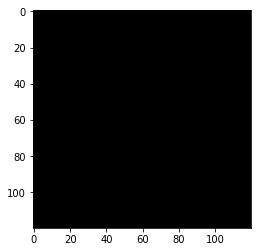

In [8]:
generator = generator_model()
noise = random.normal([1,IMAGE_SIZE])
img = generator(noise,training=False)
plt.imshow(img[0])

### Defining Descriminator Model

In [0]:
def discriminator_model():
  c2, c4, c8, c16 = 64, 128, 256, 512
  model = models.Sequential()
  
  model.add(layers.Conv2D(c2,(5,5),strides=(2,2),padding='same',input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),kernel_initializer=initializers.TruncatedNormal(stddev=0.02)))
  model.add(layers.LeakyReLU())
  
  model.add(layers.Conv2D(c4,(5,5),strides=(2,2),padding='same',kernel_initializer=initializers.TruncatedNormal(stddev=0.02)))
  model.add(layers.LeakyReLU())
  
  model.add(layers.Conv2D(c8,(5,5),strides=(2,2),padding='same',kernel_initializer=initializers.TruncatedNormal(stddev=0.02)))
  model.add(layers.LeakyReLU())
  
  model.add(layers.Conv2D(c16,(5,5),strides=(2,2),padding='same',kernel_initializer=initializers.TruncatedNormal(stddev=0.02)))
  model.add(layers.LeakyReLU())
  
  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  return model

**Testing discriminator model on the generated random image**

In [10]:
discriminator = discriminator_model()
decision = discriminator(img)
decision 

<tf.Tensor: id=2102, shape=(1, 1), dtype=float32, numpy=array([[-5.5666893e-05]], dtype=float32)>

## Defining Loss Functions


**Binary Cross-Entropy**![Binary Cross entropy](https://cdn-images-1.medium.com/max/800/1*rdBw0E-My8Gu3f_BOB6GMA.png)

In [0]:
cross_entropy = losses.BinaryCrossentropy()

**Descriminator and generator loss functions**

In [0]:
def discriminator_loss(real_output,fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Defining Optimizers

**RMSprop optimizer**

In [0]:
generator_optimizer = optimizers.RMSprop(2e-4)
discriminator_optimizer = optimizers.RMSprop(2e-4)

## Defining Hyperparameters

In [0]:
EPOCHS = 50000
BATCH_SIZE = 50
NOISE_DIM = IMAGE_SIZE
NUMBER_OF_EXAMPLES_TO_GENERATE = 16
seed = random.normal([NUMBER_OF_EXAMPLES_TO_GENERATE,NOISE_DIM])
noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

## Configuring Checkpoints

Configurung checkpoints for restoring in case of training task is interrupted.

In [0]:
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'cpkt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

## Defining traning step

In [0]:
@tf.function
def train_step(images):

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

**function for generating image every 10 epochs**

In [0]:
def generate_image(model,test_input):
  images = model(test_input,training=False)
  fig = plt.figure(figsize=(4,4))
  for i in range(NUMBER_OF_EXAMPLES_TO_GENERATE):
    plt.subplot(4,4,i+1)
    plt.imshow(images[0])
    plt.axis('off')
  plt.show()

## Training Model

W0518 20:53:20.209544 139698542983040 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0518 20:53:20.230343 139698542983040 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0518 20:53:20.250168 139698542983040 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0518 20:53:20.270199 139698542983040 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0518 20:53:20.291313 139698542983040 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0518 20:53:20.311476 139698542983040 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0518 20:53:20.335351 139698

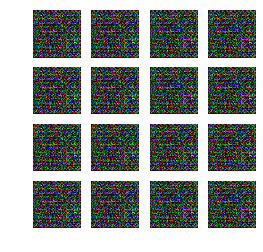

epoch n*125


In [0]:
for epoch in range(EPOCHS):
  print("epoch n*%i"%(epoch+1))
  for i,image in enumerate(X):
    train_step(image)
  display.clear_output(wait=True)
  generate_image(generator,seed)  
  if(epoch +1) % 10 == 0:
    checkpoint.save(file_prefix=checkpoint_prefix)    
display.clear_output(wait=True)
generate_image(generator,seed)